In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

nltk.download('vader_lexicon')

#Settings
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=np.nan)
sns.set()
DIMS=(20, 10)

/Users/admin/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
print("Downloading corpora...")    
nltk.download('punkt')                        # Sentence Tokenizer
nltk.download('stopwords')                    # For stopwords in all languages
nltk.download('averaged_perceptron_tagger')   # For Sentiment analysis
nltk.download('wordnet')                      # For Lemmas
print("Downloads complete.")

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Downloads complete.


In [3]:
reviews_df = pd.read_csv('Womens-Clothing-E-Commerce-Reviews.csv',index_col=0)
reviews_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Check for null values

In [6]:
reviews_df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [10]:
845/23486

0.035978881035510515

Since null values in `Review Text` column only takes up a negligible 0.04% of the dataset, we'll exclude these records.

In [4]:
reviews_df_drop = reviews_df.copy()
reviews_df_drop.dropna(axis=0, inplace=True)
reviews_df_drop.reset_index()

,index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
1,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
2,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
3,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
4,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
5,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
6,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
7,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses
8,10,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,3,0,14,General,Dresses,Dresses
9,12,1095,53,Perfect!!!,More and more i find myself reliant on the rev...,5,1,2,General Petite,Dresses,Dresses


In [33]:
reviews_df_drop.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Age group                  8
dtype: int64

In [32]:
reviews_df_drop.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,19662.00,19662.00,19662.00,19662.00,19662.00
mean,921.30,43.26,4.18,0.82,2.65
std,200.23,12.26,1.11,0.39,5.83
min,1.00,18.00,1.00,0.00,0.00
25%,861.00,34.00,4.00,1.00,0.00
50%,936.00,41.00,5.00,1.00,1.00
75%,1078.00,52.00,5.00,1.00,3.00
max,1205.00,99.00,5.00,1.00,122.00


In [8]:
reviews_df_drop['Clothing ID'].nunique()

1095

In [66]:
reviews_df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [72]:
reviews_df.shape

(23486, 11)

### Exploratory analysis

Given the age group of reviewers spans over wide range of age, we'll categorise them into separate bins (10-20], (20-30] etc. This enables subsequent analysis to be more meaningful, because based on the ratings and sentiments of each age group, the company can tailor its marketing strategies accordingly or provide a more unique shopping experience for each age group, assuming that women in the same age group tend to share some similarities.

In [8]:
bins = np.arange(0,100,10)
reviews_df_drop['Age group'] = pd.cut(reviews_df['Age'], bins)
reviews_df_drop

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Age group
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"(50, 60]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"(40, 50]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"(40, 50]"
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,"(40, 50]"
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,"(30, 40]"
7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits,"(30, 40]"
8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses,"(20, 30]"
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses,"(30, 40]"
10,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,3,0,14,General,Dresses,Dresses,"(50, 60]"
12,1095,53,Perfect!!!,More and more i find myself reliant on the rev...,5,1,2,General Petite,Dresses,Dresses,"(50, 60]"


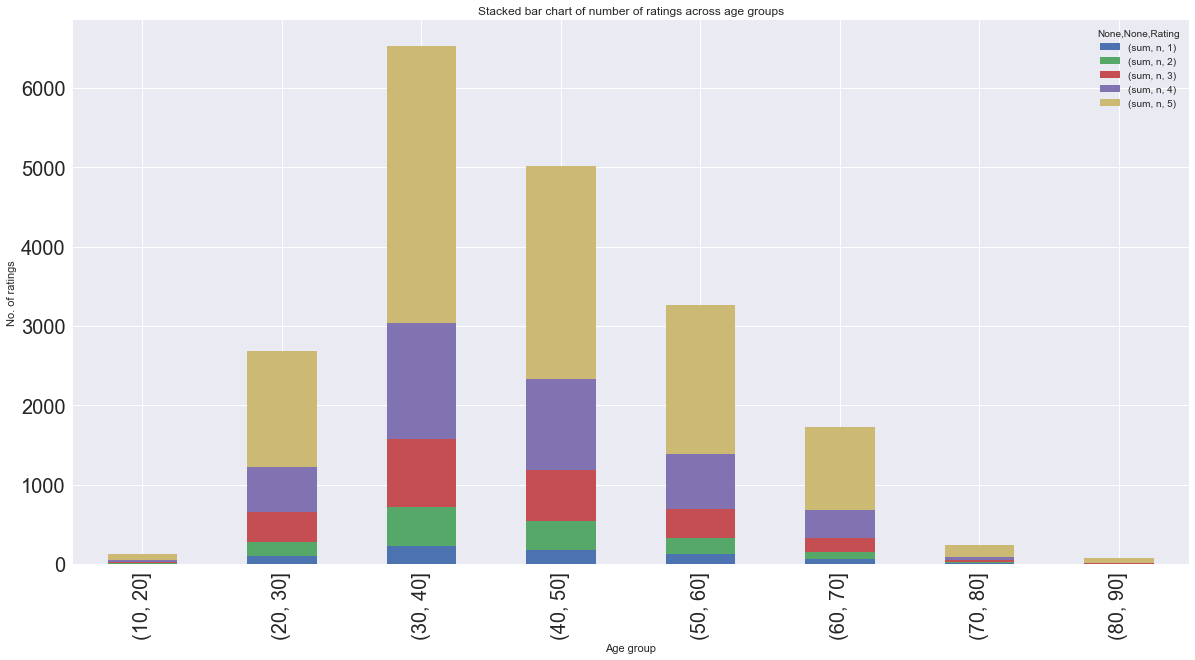

In [9]:
fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)


ratings_count_df = reviews_df_drop.groupby(['Rating', reviews_df_drop['Age group']]).size().reset_index(name='n')
ratings_count_df.columns

ratings_count_df_pivot = pd.pivot_table(ratings_count_df,index=["Age group"],
               values=["n"],
               columns=["Rating"],
               aggfunc=[np.sum])

ratings_count_df_pivot
ratings_count_df_pivot.plot(kind = 'bar', stacked=True, title = 'Stacked bar chart of number of ratings across age groups', fontsize = 20, ax=ax)
ax.set_ylabel("No. of ratings")
plt.show()

Conclusion: Women in the 30s to 40s give the most number of online reviews, followed by women in the 30s to 40s, 50s to 60s then young women in their 20s to 30s . This is surprising, given that e-commerce sites tend to be more popular among young women. Perhaps youngsters shop online but do not provide their ratings, thus these people are not captured in dataset.

The most common rating given is 5 across women from ages 20 to 70. While this could mean the e-commerce company may be doing a good job at providing a good shopping experience for their customers, analysing the sentiments of the customers' reviews will tell us a more holistic story. 

##### Text normalisation on `Review Text`

In [5]:
def clean_string(r):
    #remove regular expression and change to lowercase
    r1 = re.sub('[^A-Za-z]+', ' ', str(r))
    r1 = r1.strip().lower()
   
    #remove stopwords
    no_sw = []
    if r1 not in stopwords.words():
        no_sw.append(r1)
        
   #perform stemming
    stemmer = PorterStemmer() 
    final_list = []

    for i in no_sw:
        final_list.append(stemmer.stem(str(i)))
                
    return final_list

In [10]:
only_reviews_df = reviews_df_drop.copy()
only_reviews_df= only_reviews_df[['Clothing ID','Review Text', 'Age group', 'Recommended IND']]
only_reviews_df['Filtered Reviews'] = only_reviews_df['Review Text'].apply(clean_string)
only_reviews_df.head()

,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews
2,1077,I had such high hopes for this dress and reall...,"(50, 60]",0,[i had such high hopes for this dress and real...
3,1049,"I love, love, love this jumpsuit. it's fun, fl...","(40, 50]",1,[i love love love this jumpsuit it s fun flirt...
4,847,This shirt is very flattering to all due to th...,"(40, 50]",1,[this shirt is very flattering to all due to t...
5,1080,"I love tracy reese dresses, but this one is no...","(40, 50]",0,[i love tracy reese dresses but this one is no...
6,858,I aded this in my basket at hte last mintue to...,"(30, 40]",1,[i aded this in my basket at hte last mintue t...


##### Sentiment analysis on `Filtered reviews`

In [11]:
sid = SentimentIntensityAnalyzer()

num_records = only_reviews_df.shape[0]
ones_array = np.ones(num_records)
    
only_reviews_df['Compound score'] = ones_array

for i in range(len(only_reviews_df['Filtered Reviews'])):

    element = only_reviews_df['Filtered Reviews'].iloc[i][0]
#     print(element)
    score = sid.polarity_scores(element)
    compound = score['compound']
#     print(compound)
    only_reviews_df['Compound score'].iloc[i] = compound
only_reviews_df.head()


/Users/admin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews,Compound score
2,1077,I had such high hopes for this dress and reall...,"(50, 60]",0,[i had such high hopes for this dress and real...,0.94
3,1049,"I love, love, love this jumpsuit. it's fun, fl...","(40, 50]",1,[i love love love this jumpsuit it s fun flirt...,0.72
4,847,This shirt is very flattering to all due to th...,"(40, 50]",1,[this shirt is very flattering to all due to t...,0.92
5,1080,"I love tracy reese dresses, but this one is no...","(40, 50]",0,[i love tracy reese dresses but this one is no...,0.94
6,858,I aded this in my basket at hte last mintue to...,"(30, 40]",1,[i aded this in my basket at hte last mintue t...,0.46


##### Classify sentiments into different bins of age groups

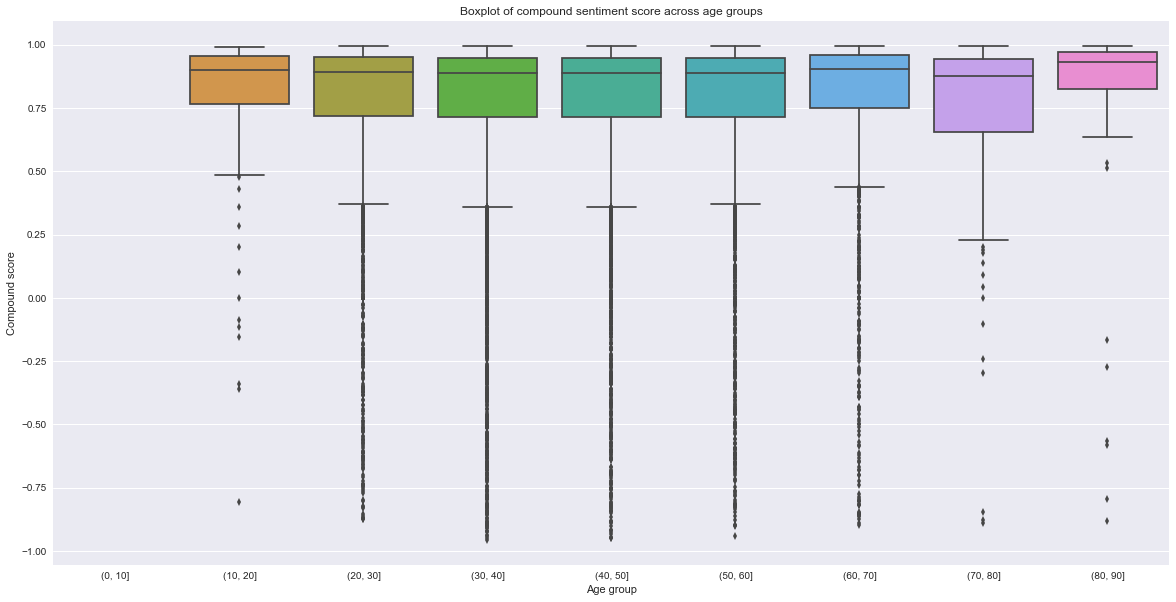

In [44]:

fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)

sns.boxplot(data=only_reviews_df[['Compound score', 'Age group']],x= 'Age group',y='Compound score', ax=ax, fontsize = 20)
ax.set_title('Boxplot of compound sentiment score across age groups', fontsize=30)

plt.show()

Conclusion: Women across all age groups have given very positive sentiments about their shopping experience, with a general compound polarity of 0.9. However, there are more outliers in sentiment scores amongst women from 20s to 70s. 

##### Classify sentiments into positive, negative, neutral

In [14]:
category = []

for i in only_reviews_df['Compound score']: 
    
    if i > 0:
        category.append('Positive')

    elif i < 0:
        category.append('Negative')

    else:
        category.append('Neutral')

only_reviews_df['Sentiment category'] = category
only_reviews_df.tail()

,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews,Compound score,Sentiment category
23481,1104,I was very happy to snag this dress at such a ...,"(30, 40]",1,[i was very happy to snag this dress at such a...,0.91,Positive
23482,862,"It reminds me of maternity clothes. soft, stre...","(40, 50]",1,[it reminds me of maternity clothes soft stret...,0.67,Positive
23483,1104,"This fit well, but the top was very see throug...","(30, 40]",0,[this fit well but the top was very see throug...,0.93,Positive
23484,1084,I bought this dress for a wedding i have this ...,"(20, 30]",1,[i bought this dress for a wedding i have this...,0.82,Positive
23485,1104,This dress in a lovely platinum is feminine an...,"(50, 60]",1,[this dress in a lovely platinum is feminine a...,0.93,Positive


##### Number of sentiment categories

In [15]:
num_sentiment_df = only_reviews_df.copy()
num_sentiment_df = num_sentiment_df[['Clothing ID', 'Sentiment category']]
num_sentiment_agg = num_sentiment_df.groupby('Sentiment category').size().reset_index(name='No. of sentiments')
num_sentiment_agg

,Sentiment category,No. of sentiments
0,Negative,1099
1,Neutral,121
2,Positive,18442


In [144]:
num_sentiment_agg.columns

Index(['Sentiment category', 'No. of sentiments'], dtype='object')

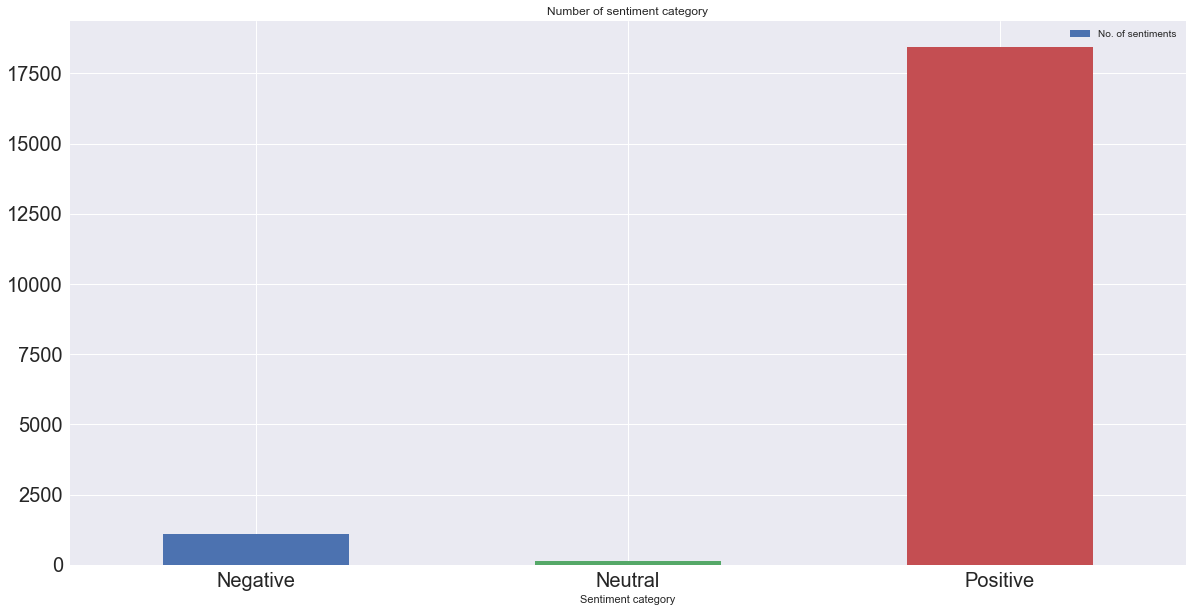

In [150]:
fig, ax = plt.subplots()
num_sentiment_agg.plot(kind='bar', x='Sentiment category', y='No. of sentiments', figsize = DIMS, ax=ax, rot=0, fontsize = 20)
fig.suptitle('Number of sentiment category', fontsize=16)
ax.legend([, fontsize=12)

Wordcloud for each category of sentiments

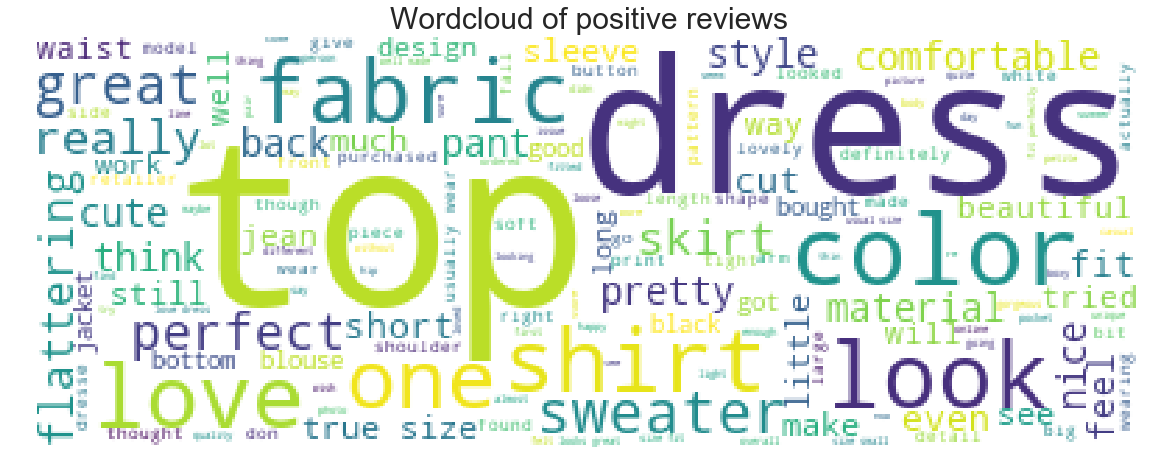

In [123]:

positive_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Positive', 'Filtered Reviews'].tolist()

# print(positive_reviews[:10])

fig = plt.figure(figsize=DIMS)
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(pos_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of positive reviews", fontsize=30)
plt.show()

In [142]:
negative_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Negative', 'Filtered Reviews']

neg_rev_desc = ''
for i in negative_reviews:
    for x in i:
        neg_rev_desc = neg_rev_desc + '' + x  


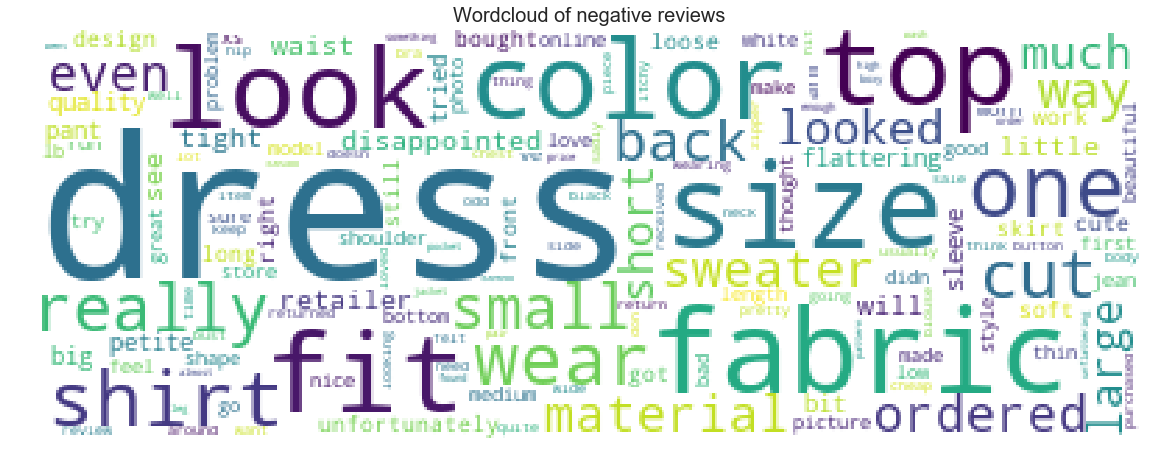

In [122]:
fig = plt.figure(figsize=DIMS)
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(neg_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of negative reviews", fontsize=30)
plt.show()

Conclusion: 

The main elements contributing to both positive and negative reviews are top, dress. However, words like fit and size are more commonly associated with negative reviews, while words such as fabric and colour appear more often with positive reviews. While it seems that generally, the experience from the purchase of tops and dresses from this e-commerce company generate mixed reviews, I feel that the company can continue with its current choice of fabric and colour it chose for its tops and dresses, given that the proportion of positive reviews are significantly larger than negative reviews. 

In [141]:
neutral_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Neutral', 'Filtered Reviews']

neut_rev_desc = ''
for i in neutral_reviews:
    for x in i:
        neut_rev_desc = neut_rev_desc + '' + x

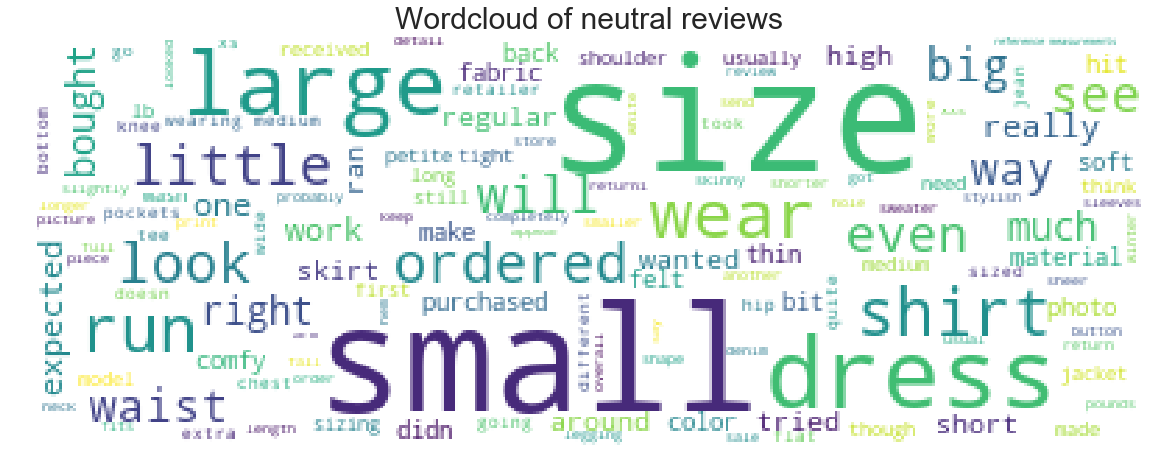

In [125]:
fig = plt.figure(figsize=DIMS)
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(neut_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of neutral reviews", fontsize=30)
plt.show()

#### Apply the Naïve Bayes Classification Algorithm on Sentiment category to predict if item is recommended

##### Train 

In [16]:
X = only_reviews_df['Sentiment category']
y = only_reviews_df['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

Apply CountVectorizer and TdidfTransformer transformations

In [17]:
count_vect = CountVectorizer()
tfidf_tfm = TfidfTransformer()
train_df_counts = count_vect.fit_transform(X_train)
train_df_tfidf = tfidf_tfm.fit_transform(train_df_counts)

Fit the model using Naïve Bayes Classification.

In [18]:
clf = MultinomialNB().fit(train_df_tfidf, y_train)

##### Test

In [19]:
count_test_vect = count_vect.transform(X_test)
y_predict = clf.predict(count_test_vect)

###### Evaluate Model

Compare results in predicted model against the original results

In [25]:
y_confusion_df = pd.DataFrame({"y_test": y_test, "y_predict" : y_predict} )
y_confusion_df.head()

,y_test,y_predict
18520,1,1
12634,0,1
5498,1,1
404,1,1
12845,0,1


In [70]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[ 171,  700],
       [  96, 3949]])

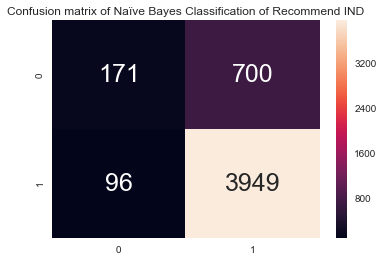

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of Naïve Bayes Classification of Recommend IND")
plt.show()

In [88]:
print("True negatives:", (cm[0][0]))
print("True positives:", (cm[1][1]))
print("False negatives:", (cm[0][1]))
print("Total:", (sum(sum(cm))))
print("Accuracy:", ((cm[0][0] + cm[1][1])/sum(sum(cm))))
print("Proportion of False negatives:", (cm[0][1] /sum(sum(cm))))

True negatives: 171
True positives: 3949
False negatives: 700
Total: 4916
Accuracy: 0.8380797396257119
Proportion of False negatives: 0.14239218877135884


Conclusion: Accuracy of model is 83.8%

More importantly, 14.2% of the time, the model wrongly predicts that a customer would recommend her product based on her sentiments, when she actually would not have 

##### Inspect the wrongly classified reviews.

In [27]:
only_reviews_df['id'] = only_reviews_df.index
y_confusion_df['id'] = y_confusion_df.index
# y_confusion_df.head()

wrong_indices = y_confusion_df[
    y_confusion_df['y_test'] != y_confusion_df['y_predict']].index

mismatch_df = only_reviews_df.merge(y_confusion_df, on='id')
mismatch_df = mismatch_df[mismatch_df['id'].isin(wrong_indices)]
mismatch_df.head()

,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews,Compound score,Sentiment category,id,y_test,y_predict
0,858,"I ordered this in carbon for store pick up, an...","(30, 40]",1,[i ordered this in carbon for store pick up an...,-0.09,Negative,7,1,0
3,949,I have been waiting for this sweater coat to s...,"(30, 40]",0,[i have been waiting for this sweater coat to ...,0.48,Positive,26,0,1
11,822,Why do designers keep making crop tops??!! i c...,"(30, 40]",0,[why do designers keep making crop tops i can ...,0.92,Positive,71,0,1
25,829,I love the metallic colors of this top and fig...,"(40, 50]",1,[i love the metallic colors of this top and fi...,-0.58,Negative,154,1,0
30,895,I was worried about this item when i ordered i...,"(30, 40]",0,[i was worried about this item when i ordered ...,0.88,Positive,185,0,1


In [29]:
spl = mismatch_df.sample()
print(spl[['Clothing ID', 'id','y_test','y_predict']])
print()
print(spl.iloc[0]['Filtered Reviews'])

     Clothing ID    id  y_test  y_predict
445          872  2150       0          1

['loved this shirt so much that i bought in colors love the luxurious feel of the silky flowing fabric that flatters in all the best ways however after washing per instructions the fabric lost its good qualities and turned into a blah pilled mess that gathers at the seams especially the bottom seam tried dry cleaning another shirt and it came out the same way as washing looks like a cheap lackluster layering top now and definitely won t last another season so disappointed if you ca']


The above sample shows how the model wrongly predicts that a customer would recommend her product based on her sentiments, when she actually would not have. Hence the model should be interpreted and used with caution.

#### Future Work

Given that this is a general dataset, the current analysis is limited to identification of trends and insights to help make broad business decisions. In order to build a model that customised recommendations to customers based on their history, then a query into the database that provides customers' purchasing history would be necessary. In this way, one would be able to employ collaborative filtering and personalise customers' online shopping experiences. Such a recommendation system is gaining traction in numerous e-commerce sites. Thus, this e-commerce company can consider adopting such a model to enhance its customers' web experience and boost its revenue.
